# Sentiment Analysis using recurrent neural networks

In the next notebook a implmentation of deep learning in sentiment analysis is presented. The dataset to study contains tweets of an airline with positive, negative or neutral sentiment. Recurrent neural networks are used to build the model, and random search and grid search for tuning the hyparameters. Besides that a pre-trained Embedding is used to add a Embedding Layer in the neural network

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, Masking
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import keras.optimizers
from keras.layers import Embedding, LSTM, Dense, Dropout

Using TensorFlow backend.


## Preprocessing data

In [2]:
# load the dataset
dataset=pd.read_excel('dataset_tweets.xlsx', parse_dates=['tweet_created'])
print(dataset.shape)
print(dataset.columns)
dataset.head()

(14640, 20)
Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'airline_sentiment',
       'airline_sentiment:confidence', 'negativereason',
       'negativereason:confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2015-02-25 05:24:00,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:00,570306000000000000,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2015-02-25 01:53:00,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:00,570301000000000000,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2015-02-25 10:01:00,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:00,570301000000000000,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2015-02-25 03:05:00,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:00,570301000000000000,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2015-02-25 05:50:00,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:00,570301000000000000,NaN,Pacific Time (US & Canada)


In [3]:
# extract the columns to use
dataset=dataset[['airline_sentiment','text']]
dataset.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [4]:
dataset['text'][3]

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

In [5]:
dataset['text'][10]

'@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24'

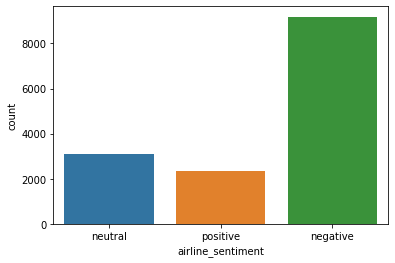

In [6]:
import seaborn as sns

sns.countplot(x='airline_sentiment', data=dataset)

In the graph we can see that the data is unbalanced. However, in the exercise we will use tha data in this way. Another preprocessing for balancing the data is for further researchs.

The next functions uses regular expressions for deleting and replacing special characters in order to have a better corpus.

In [7]:
TAG_RE = re.compile(r'@\w+')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(text):
    # Removing html tags
    text = remove_tags(text)

    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [8]:
x=[]
tweets=list(dataset['text'])
for tweet in tweets:
    x.append(preprocess_text(tweet))

Here we can see that the same tweets we called before don't have numbers and special characters now

In [9]:
x[3]

' it really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse'

In [10]:
x[10]

' did you know that suicide is the second leading cause of death among teens '

This next function converts the tweet into a sequence of integers using the Tokenizer from keras. Besides that other information of the token dictionary are extracted

In [11]:
def make_sequences(texts,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)
    
    return word_idx, idx_word, num_words, word_counts, sequences

In [12]:
word_idx,idx_word, num_words, word_counts,x=make_sequences(x)

There are 12861 unique words.


In [13]:
x[3]

[11, 122, 3481, 1, 4299, 4300, 954, 10, 14, 2958, 3482, 53, 45, 17, 472, 2595]

In [14]:
x[10]

[109, 3, 100, 15, 2360, 9, 2, 583, 1985, 728, 12, 1414, 1662, 2361]

Now, with the tweets converted into sequences, the labels (neagetive, positive and neutral) are converted into categorical labels.

In [15]:
from keras.utils import to_categorical

def string_to_int(text):
    if text=='positive':
        return 0
    elif text=='negative':
        return 1
    else:
        return 2

y=list(map(string_to_int,dataset['airline_sentiment']))

y=to_categorical(y, num_classes=3)

print(y[0:5])
dataset['airline_sentiment'].head()

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

## Splitting data for training

Before using the train_test_split method from scikitlearn, a padding method is applied in the data in order to having sequences with the same length. This method receives a length. That's why the maximum length in the sequences is calculated. So, if we have a maximum length of 10, when we apply padding to a sequence with 3 integers, 7 more zeros are added to the sequence

In [16]:
def max_len(a):
    result=0
    for i in range(0,len(a)):
        if len(a[i])>result:
            result=len(a[i])
    return result

In [17]:
max_length=max_len(x)
x = pad_sequences(x, padding='post', maxlen=max_length)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
print(len(x_train),len(y_train))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.30, random_state=42)

10248 10248


## Embedding

For the embedding, a pre-trained word embedding is used

In [18]:
import os
from keras.utils import get_file

# Vectors to use
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.zip'

# Download word embeddings if they are not present
if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip',
                             'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')

# Load in unzipped file
glove_vectors = './glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

In [19]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

vectors[100], words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

In [20]:
vectors.shape

(400000, 100)

In this part, only the common words between the dataset and the embedding stay in the embedding

In [21]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 3383 words without pre-trained embeddings.


In [22]:
import gc
gc.enable()
del vectors
gc.collect()

80

In [23]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/home/sebashc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sebashc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## Creating the model

The structure of the model to be tuned is: an embedding layer, a masking, n possible LSTM layers, a final LSTM layer, a dense layer, a dropout and a final dense layer. In this model the LSTM cells, the LSTM layers, the optimizer, the dropout rate, the neurons in the dense layers and the learning rate can be set

In [24]:
def create_model(lstm_cells=64, lstm_layers=1, optimizer="adam",
                neurons=128, dropout_rate=0.5, learning_rate=0.1):
    
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    if optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model = Sequential()
    
    model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
    
    model.add(Masking())
    
    if lstm_layers > 1:
        for i in range(0,lstm_layers-1):
            model.add(
                LSTM(
                    units=lstm_cells,
                    return_sequences=True,
                    recurrent_dropout=dropout_rate))
            
    model.add(
            LSTM(
                units=lstm_cells,
                return_sequences=False,
                dropout=dropout_rate))
    
    model.add(Dense(units=neurons, activation='relu'))
    
    # Dropout for regularization
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

## Hyperparameter tuning

The random search and the grid search algortihm are used for the hyper parameter tuning.

### Random Search

In [25]:
from scipy.stats import randint as sp_randint

#param_dist={"lstm_cells":sp_randint(64,100),
 #           "epochs":sp_randint(20,100),
  #          "lstm_layers":sp_randint(1,2),
   #         "neurons":sp_randint(64,128),
    #        "optimizer":sp_randint(1,2),
     #       "learning_rate":sp_randint(0.05,0.1),
      #      "dropout_rate":sp_randint(0.2,0.5)}

param_dist={"optimizer":["adam","rmsprop"],
            "learning_rate":[0.001,0.01],
            "lstm_layers":[1,2,3],
            "lstm_cells":[64,128,200],
            "neurons":[64,128,200],
            "dropout_rate":[0.1,0.2,0.5],
            "epochs":[10,25,50],
           "batch_size":[800,1000,2000]}

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from time import time

# funtion to present the result of the random and grid search

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

model=KerasClassifier(build_fn=create_model)

n_iter_search = 3
random_model=RandomizedSearchCV(estimator=model,param_distributions=param_dist,n_iter=n_iter_search)

start = time()
history=random_model.fit(x_train,y_train,validation_data=(x_val,y_val))
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_model.cv_results_)

/home/sebashc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 6832 samples, validate on 4392 samples
Epoch 1/50
6832/6832 [==============================] - 4s 517us/step - loss: 1.0810 - accuracy: 0.5271 - val_loss: 1.0315 - val_accuracy: 0.6407
Epoch 2/50
6832/6832 [==============================] - 2s 258us/step - loss: 1.0109 - accuracy: 0.6200 - val_loss: 0.9286 - val_accuracy: 0.6407
Epoch 3/50
6832/6832 [==============================] - 2s 264us/step - loss: 0.9070 - accuracy: 0.6199 - val_loss: 0.8379 - val_accuracy: 0.6407
Epoch 4/50
6832/6832 [==============================] - 2s 253us/step - loss: 0.8987 - accuracy: 0.6199 - val_loss: 0.8493 - val_accuracy: 0.6407
Epoch 5/50
6832/6832 [==============================] - 2s 254us/step - loss: 0.8811 - accuracy: 0.6199 - val_loss: 0.8371 - val_accuracy: 0.6407
Epoch 6/50
6832/6832 [==============================] - 2s 253us/step - loss: 0.8721 - accuracy: 0.6200 - val_loss: 0.8505 - val_accuracy: 0.6407
Epoch 7/50
6832/6832 [==============================] - 2s 249us/step - loss

Epoch 6/50
6832/6832 [==============================] - 2s 252us/step - loss: 0.8640 - accuracy: 0.6273 - val_loss: 0.8431 - val_accuracy: 0.6407
Epoch 7/50
6832/6832 [==============================] - 2s 252us/step - loss: 0.8557 - accuracy: 0.6275 - val_loss: 0.8233 - val_accuracy: 0.6407
Epoch 8/50
6832/6832 [==============================] - 2s 252us/step - loss: 0.8425 - accuracy: 0.6275 - val_loss: 0.8150 - val_accuracy: 0.6407
Epoch 9/50
6832/6832 [==============================] - 2s 253us/step - loss: 0.8341 - accuracy: 0.6287 - val_loss: 0.8020 - val_accuracy: 0.6421
Epoch 10/50
6832/6832 [==============================] - 2s 253us/step - loss: 0.8207 - accuracy: 0.6314 - val_loss: 0.7928 - val_accuracy: 0.6469
Epoch 11/50
6832/6832 [==============================] - 2s 257us/step - loss: 0.8079 - accuracy: 0.6420 - val_loss: 0.7723 - val_accuracy: 0.6621
Epoch 12/50
6832/6832 [==============================] - 2s 252us/step - loss: 0.7906 - accuracy: 0.6538 - val_loss: 0.755

6832/6832 [==============================] - 5s 695us/step - loss: 0.7381 - accuracy: 0.6975 - val_loss: 0.6812 - val_accuracy: 0.7222
Epoch 17/25
6832/6832 [==============================] - 5s 719us/step - loss: 0.7413 - accuracy: 0.6966 - val_loss: 0.6750 - val_accuracy: 0.7450
Epoch 18/25
6832/6832 [==============================] - 5s 707us/step - loss: 0.6878 - accuracy: 0.7302 - val_loss: 0.6544 - val_accuracy: 0.7425
Epoch 19/25
6832/6832 [==============================] - 5s 697us/step - loss: 0.7090 - accuracy: 0.7143 - val_loss: 0.6680 - val_accuracy: 0.7311
Epoch 20/25
6832/6832 [==============================] - 5s 693us/step - loss: 0.6849 - accuracy: 0.7275 - val_loss: 0.9197 - val_accuracy: 0.5952
Epoch 21/25
6832/6832 [==============================] - 5s 694us/step - loss: 0.7103 - accuracy: 0.7103 - val_loss: 0.6562 - val_accuracy: 0.7568
Epoch 22/25
6832/6832 [==============================] - 5s 694us/step - loss: 0.6858 - accuracy: 0.7323 - val_loss: 0.6063 - val_

6832/6832 [==============================] - 3s 512us/step - loss: 0.7114 - accuracy: 0.7146 - val_loss: 0.6565 - val_accuracy: 0.7345
Epoch 25/25
3416/3416 [==============================] - 1s 150us/step
Train on 6832 samples, validate on 4392 samples
Epoch 1/25
6832/6832 [==============================] - 5s 769us/step - loss: 0.9935 - accuracy: 0.5969 - val_loss: 0.8390 - val_accuracy: 0.6407
Epoch 2/25
6832/6832 [==============================] - 3s 510us/step - loss: 0.9069 - accuracy: 0.6162 - val_loss: 0.8465 - val_accuracy: 0.6407
Epoch 3/25
6832/6832 [==============================] - 3s 510us/step - loss: 0.8918 - accuracy: 0.6162 - val_loss: 0.8283 - val_accuracy: 0.6407
Epoch 4/25
6832/6832 [==============================] - 4s 513us/step - loss: 0.8693 - accuracy: 0.6164 - val_loss: 0.8034 - val_accuracy: 0.6407
Epoch 5/25
6832/6832 [==============================] - 3s 511us/step - loss: 0.8478 - accuracy: 0.6169 - val_loss: 0.7771 - val_accuracy: 0.6418
Epoch 6/25
6832/

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

Y_pred = random_model.predict(x_test)

CM = confusion_matrix(np.argmax(y_test, axis = 1), Y_pred)
print("\n"+"Confusion Matrix:" + "\n")
print(CM)

print("\n"+"Classification Report"+"\n")
print(classification_report(Y_pred,np.argmax(y_test, axis = 1)))


Confusion Matrix:

[[ 484  152   58]
 [  81 2610  123]
 [  81  439  364]]

Classification Report

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       646
           1       0.93      0.82      0.87      3201
           2       0.41      0.67      0.51       545

    accuracy                           0.79      4392
   macro avg       0.68      0.74      0.70      4392
weighted avg       0.83      0.79      0.80      4392



#### Use of the best model

To use the best model we add again the validation data to the training data and re-train the model to obtain better results

In [29]:
# creating new sets for training the model again

x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.30, random_state=42)

In [34]:
# creating model with the optimal hyperparameters

model=create_model(optimizer='rmsprop',neurons=64,lstm_layers=3,lstm_cells=64,learning_rate=0.01,dropout_rate=0.2)

start = time()
history=model.fit(x_train2,y_train2, epochs=25, batch_size=800)
print("The model took %.2f seconds with optimal hyperparamenters." %(time() - start))

Epoch 1/25
10248/10248 [==============================] - 9s 836us/step - loss: 0.9941 - accuracy: 0.5441
Epoch 2/25
10248/10248 [==============================] - 6s 568us/step - loss: 0.9162 - accuracy: 0.6205
Epoch 3/25
10248/10248 [==============================] - 6s 564us/step - loss: 0.9277 - accuracy: 0.5862
Epoch 4/25
10248/10248 [==============================] - 6s 564us/step - loss: 0.8566 - accuracy: 0.6212
Epoch 5/25
10248/10248 [==============================] - 6s 564us/step - loss: 0.9263 - accuracy: 0.6227
Epoch 6/25
10248/10248 [==============================] - 6s 562us/step - loss: 0.8686 - accuracy: 0.6227
Epoch 7/25
10248/10248 [==============================] - 6s 572us/step - loss: 0.8324 - accuracy: 0.6512
Epoch 8/25
10248/10248 [==============================] - 6s 572us/step - loss: 0.8303 - accuracy: 0.6293
Epoch 9/25
10248/10248 [==============================] - 6s 572us/step - loss: 0.7718 - accuracy: 0.6759
Epoch 10/25
10248/10248 [=====================

#### Results


Confusion Matrix:

[[ 484  152   58]
 [  81 2610  123]
 [  81  439  364]]

Classification Report

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       646
           1       0.93      0.82      0.87      3201
           2       0.41      0.67      0.51       545

    accuracy                           0.79      4392
   macro avg       0.68      0.74      0.70      4392
weighted avg       0.83      0.79      0.80      4392



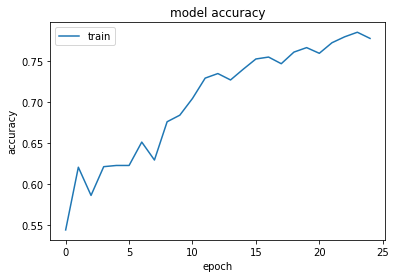

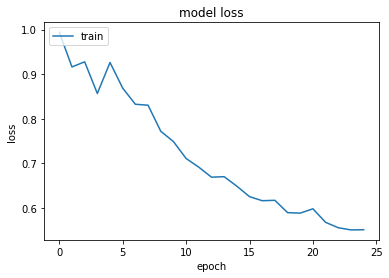

In [38]:
# summary statistics

Y_pred = random_model.predict(x_test2)

CM = confusion_matrix(np.argmax(y_test2, axis = 1), Y_pred)
print("\n"+"Confusion Matrix:" + "\n")
print(CM)

print("\n"+"Classification Report"+"\n")
print(classification_report(Y_pred,np.argmax(y_test2, axis = 1)))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Analysing the confusion matrix an the classification repot we can say that the model behaves well for the three tweet sentiment, with a little bias for the negative sentiments.

On the othe hand, the accuracy and the loss graphs give evidence that a better training can be done and we can expect better results. For example, more epochs or a smaller batch size.

### Grid Search

The disctionary of parameters for the grid search contains less options that the random search due to a lack in the computational capacity. When more parameters were added, the PC got stuck.

A better Grid can be made in order to pursue better results

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from time import time

param_dist={"optimizer":["adam"],
            "learning_rate":[0.01],
            "lstm_layers":[2,3],
            "lstm_cells":[64],
            "neurons":[64],
            "dropout_rate":[0.2,0.5],
            "epochs":[25],
           "batch_size":[1000]}

In [26]:
# run grid search
from sklearn.model_selection import GridSearchCV

model=KerasClassifier(build_fn=create_model)

grid_search = GridSearchCV(estimator=model, param_grid=param_dist)

start = time()
history=grid_search.fit(x_train, y_train, validation_data=(x_val,y_val))

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


/home/sebashc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 6832 samples, validate on 4392 samples
Epoch 1/25
6832/6832 [==============================] - 6s 838us/step - loss: 0.9559 - accuracy: 0.5607 - val_loss: 0.8460 - val_accuracy: 0.6407
Epoch 2/25
6832/6832 [==============================] - 3s 455us/step - loss: 0.8699 - accuracy: 0.6199 - val_loss: 0.7738 - val_accuracy: 0.6434
Epoch 3/25
6832/6832 [==============================] - 3s 474us/step - loss: 0.8445 - accuracy: 0.6194 - val_loss: 0.8028 - val_accuracy: 0.6771
Epoch 4/25
6832/6832 [==============================] - 3s 480us/step - loss: 0.8004 - accuracy: 0.6708 - val_loss: 0.7068 - val_accuracy: 0.7122
Epoch 5/25
6832/6832 [==============================] - 3s 449us/step - loss: 0.7550 - accuracy: 0.6897 - val_loss: 0.6734 - val_accuracy: 0.7268
Epoch 6/25
6832/6832 [==============================] - 3s 451us/step - loss: 0.7194 - accuracy: 0.6996 - val_loss: 0.6424 - va

6832/6832 [==============================] - 5s 676us/step - loss: 0.7223 - accuracy: 0.6988 - val_loss: 0.6552 - val_accuracy: 0.7384
Epoch 6/25
6832/6832 [==============================] - 5s 675us/step - loss: 0.6856 - accuracy: 0.7204 - val_loss: 0.6274 - val_accuracy: 0.7541
Epoch 7/25
6832/6832 [==============================] - 5s 675us/step - loss: 0.6524 - accuracy: 0.7405 - val_loss: 0.6106 - val_accuracy: 0.7605
Epoch 8/25
6832/6832 [==============================] - 5s 675us/step - loss: 0.6171 - accuracy: 0.7538 - val_loss: 0.5897 - val_accuracy: 0.7684
Epoch 9/25
6832/6832 [==============================] - 5s 678us/step - loss: 0.6041 - accuracy: 0.7573 - val_loss: 0.5923 - val_accuracy: 0.7678
Epoch 10/25
6832/6832 [==============================] - 5s 677us/step - loss: 0.5839 - accuracy: 0.7664 - val_loss: 0.6038 - val_accuracy: 0.7511
Epoch 11/25
6832/6832 [==============================] - 5s 676us/step - loss: 0.5954 - accuracy: 0.7610 - val_loss: 0.5821 - val_accu

6832/6832 [==============================] - 3s 477us/step - loss: 0.5845 - accuracy: 0.7676 - val_loss: 0.5553 - val_accuracy: 0.7755
Epoch 14/25
6832/6832 [==============================] - 3s 454us/step - loss: 0.5896 - accuracy: 0.7598 - val_loss: 0.5940 - val_accuracy: 0.7641
Epoch 15/25
6832/6832 [==============================] - 3s 452us/step - loss: 0.5880 - accuracy: 0.7645 - val_loss: 0.5722 - val_accuracy: 0.7760
Epoch 16/25
6832/6832 [==============================] - 3s 455us/step - loss: 0.5914 - accuracy: 0.7660 - val_loss: 0.5661 - val_accuracy: 0.7700
Epoch 17/25
6832/6832 [==============================] - 3s 453us/step - loss: 0.5705 - accuracy: 0.7695 - val_loss: 0.5587 - val_accuracy: 0.7762
Epoch 18/25
6832/6832 [==============================] - 3s 455us/step - loss: 0.5594 - accuracy: 0.7784 - val_loss: 0.5455 - val_accuracy: 0.7780
Epoch 19/25
6832/6832 [==============================] - 3s 452us/step - loss: 0.5546 - accuracy: 0.7774 - val_loss: 0.5465 - val_

10248/10248 [==============================] - 4s 435us/step - loss: 0.5333 - accuracy: 0.7909 - val_loss: 0.5129 - val_accuracy: 0.7996
Epoch 22/25
10248/10248 [==============================] - 4s 436us/step - loss: 0.5157 - accuracy: 0.7942 - val_loss: 0.5095 - val_accuracy: 0.7999
Epoch 23/25
10248/10248 [==============================] - 4s 437us/step - loss: 0.5173 - accuracy: 0.7948 - val_loss: 0.5297 - val_accuracy: 0.7917
Epoch 24/25
10248/10248 [==============================] - 4s 434us/step - loss: 0.5295 - accuracy: 0.7898 - val_loss: 0.5312 - val_accuracy: 0.7908
Epoch 25/25
10248/10248 [==============================] - 4s 434us/step - loss: 0.5108 - accuracy: 0.7941 - val_loss: 0.5123 - val_accuracy: 0.7962
GridSearchCV took 1381.59 seconds for 4 candidate parameter settings.


NameError: name 'report' is not defined

In [27]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(grid_search.cv_results_)            

Model with rank: 1
Mean validation score: 0.770 (std: 0.006)
Parameters: {'batch_size': 1000, 'dropout_rate': 0.5, 'epochs': 25, 'learning_rate': 0.01, 'lstm_cells': 64, 'lstm_layers': 2, 'neurons': 64, 'optimizer': 'adam'}

Model with rank: 2
Mean validation score: 0.768 (std: 0.003)
Parameters: {'batch_size': 1000, 'dropout_rate': 0.2, 'epochs': 25, 'learning_rate': 0.01, 'lstm_cells': 64, 'lstm_layers': 3, 'neurons': 64, 'optimizer': 'adam'}

Model with rank: 3
Mean validation score: 0.764 (std: 0.002)
Parameters: {'batch_size': 1000, 'dropout_rate': 0.5, 'epochs': 25, 'learning_rate': 0.01, 'lstm_cells': 64, 'lstm_layers': 3, 'neurons': 64, 'optimizer': 'adam'}



#### Use of the best model

In [30]:
# creating model with the optimal hyperparameters

model=create_model(optimizer='adam',neurons=64,lstm_layers=2,lstm_cells=64,learning_rate=0.01,dropout_rate=0.5)

start = time()
history=model.fit(x_train2,y_train2, epochs=25, batch_size=1000)
print("The model took %.2f seconds with optimal hyperparamenters." %(time() - start))

Epoch 1/25
10248/10248 [==============================] - 6s 589us/step - loss: 0.9583 - accuracy: 0.5973
Epoch 2/25
10248/10248 [==============================] - 4s 390us/step - loss: 0.8592 - accuracy: 0.6206
Epoch 3/25
10248/10248 [==============================] - 4s 404us/step - loss: 0.7787 - accuracy: 0.6585
Epoch 4/25
10248/10248 [==============================] - 4s 439us/step - loss: 0.7057 - accuracy: 0.7157
Epoch 5/25
10248/10248 [==============================] - 4s 383us/step - loss: 0.6668 - accuracy: 0.7309
Epoch 6/25
10248/10248 [==============================] - 4s 383us/step - loss: 0.6454 - accuracy: 0.7403
Epoch 7/25
10248/10248 [==============================] - 4s 383us/step - loss: 0.6226 - accuracy: 0.7528
Epoch 8/25
10248/10248 [==============================] - 4s 382us/step - loss: 0.6077 - accuracy: 0.7572
Epoch 9/25
10248/10248 [==============================] - 4s 397us/step - loss: 0.6031 - accuracy: 0.7610
Epoch 10/25
10248/10248 [=====================

#### Results


Confusion Matrix:

[[ 426  191   77]
 [  39 2653  122]
 [  53  413  418]]

Classification Report

              precision    recall  f1-score   support

           0       0.61      0.82      0.70       518
           1       0.94      0.81      0.87      3257
           2       0.47      0.68      0.56       617

    accuracy                           0.80      4392
   macro avg       0.68      0.77      0.71      4392
weighted avg       0.84      0.80      0.81      4392



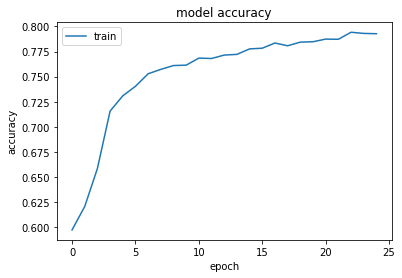

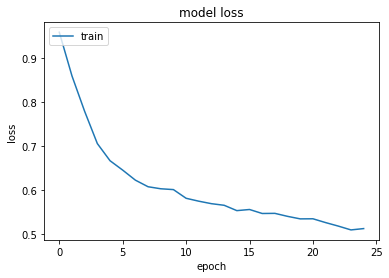

In [31]:
Y_pred = grid_search.predict(x_test)

CM = confusion_matrix(np.argmax(y_test, axis = 1), Y_pred)
print("\n"+"Confusion Matrix:" + "\n")
print(CM)

print("\n"+"Classification Report"+"\n")
print(classification_report(Y_pred,np.argmax(y_test, axis = 1)))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Analysing the confusion matrix an the classification repot we can say that the model behaves well for the three tweet sentiment, with a little bias for the negative sentiments.

On the othe hand, the accuracy and the loss graphs give evidence that a better training can be done and we can expect better results. For example, more epochs or a smaller batch size.

The best model was found though Grid Search because the F1 Score in this case is 0.80

## References

https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/